Error retrieving LST data: Invalid GeoJSON geometry.


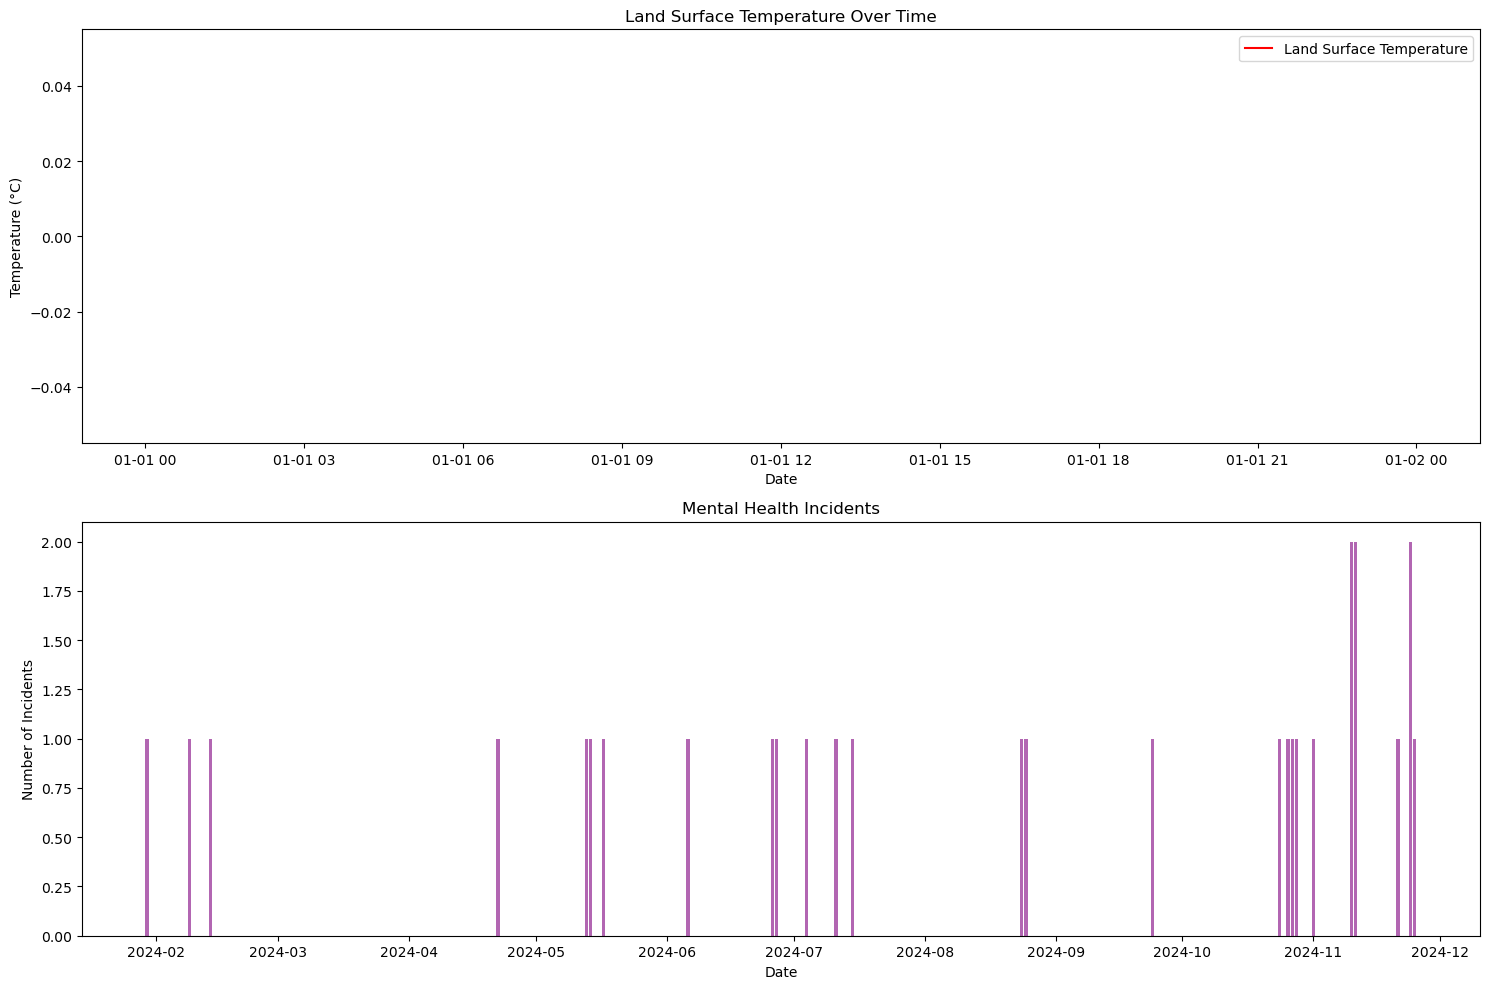

Analysis failed: agg function failed [how->mean,dtype->object]


In [18]:
def get_lst_data(latitude, longitude, start_date, end_date):
    """Get daily LST values from Landsat-8"""
    try:
        point = ee.Geometry.Point([longitude, latitude])
        
        # Import Landsat 8 collection
        l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(point)
        
        def calculate_lst(image):
            # Select thermal band and apply scaling
            lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
            return image.addBands(lst.rename('LST'))
        
        # Map over collection
        lst_collection = l8.map(calculate_lst)
        
        # Extract values
        lst_series = lst_collection \
            .select('LST') \
            .getRegion({
                'geometry': point,
                'scale': 30,
                'reducer': ee.Reducer.mean()
            }).getInfo()
        
        # Convert to DataFrame
        if lst_series and len(lst_series) > 1:
            df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
            df['datetime'] = pd.to_datetime(df['time'], unit='ms')
            df = df[['datetime', 'LST']]
            return df
        
        print("No LST data found for the specified period")
        return pd.DataFrame(columns=['datetime', 'LST'])
        
    except Exception as e:
        print(f"Error retrieving LST data: {e}")
        return pd.DataFrame(columns=['datetime', 'LST'])

def analyze_health_climate_correlation(health_data, latitude, longitude):
    """Analyze correlation between health incidents and climate data"""
    try:
        start_date = health_data['date'].min().strftime('%Y-%m-%d')
        end_date = health_data['date'].max().strftime('%Y-%m-%d')
        
        # Get LST data
        lst_data = get_lst_data(latitude, longitude, start_date, end_date)
        
        # Merge with health data
        merged_data = pd.merge(
            health_data,
            lst_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        
        # Add heatwave classification (LST > 30°C)
        merged_data['is_heatwave'] = merged_data['LST'] > 30

        # Convert 'datetime' to datetime type
        merged_data['datetime'] = pd.to_datetime(merged_data['datetime'], errors='coerce')

        # Convert 'LST' to numeric type
        merged_data['LST'] = pd.to_numeric(merged_data['LST'], errors='coerce')

        # Ensure 'is_heatwave' is boolean and handle NaN values
        merged_data['is_heatwave'] = merged_data['is_heatwave'].fillna(False).astype(bool)
        
        return merged_data
        
    except Exception as e:
        print(f"Analysis failed: {e}")
        return None

# Main execution
try:
    # Rahima Moolah Hospital coordinates
    latitude = -26.1751
    longitude = 27.9697
    
    # Load health data
    health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
    health_data['date'] = pd.to_datetime(health_data['date'])
    
    # Run analysis
    merged_data = analyze_health_climate_correlation(health_data, latitude, longitude)
    
    if merged_data is not None and not merged_data.empty:
        # Create plots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Temperature plot
        ax1.plot(merged_data['datetime'], merged_data['LST'], 
                 label='Land Surface Temperature', color='red')
        ax1.set_title('Land Surface Temperature Over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Temperature (°C)')
        ax1.legend()
        
        # Mental health incidents
        diagnosis_counts = merged_data.groupby('date')['diagnosis'].count()
        ax2.bar(diagnosis_counts.index, diagnosis_counts.values, 
                color='purple', alpha=0.6)
        ax2.set_title('Mental Health Incidents')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Number of Incidents')
        
        plt.tight_layout()
        plt.show()
        
        # Heatwave analysis
        if 'is_heatwave' in merged_data.columns:
            heatwave_stats = merged_data.groupby('is_heatwave')['diagnosis'].agg(['count', 'mean'])
            print("\nIncidents during heatwave vs non-heatwave days:")
            print(heatwave_stats)
            
        # Analysis of incidents during heatwaves
        if 'is_heatwave' in merged_data.columns:
            # Count the number of incidents during heatwave and non-heatwave days
            heatwave_stats = merged_data.groupby('is_heatwave')['diagnosis'].count().reset_index()
            heatwave_stats = heatwave_stats.rename(columns={'diagnosis': 'incident_count'})
            print("\nIncidents during heatwave vs non-heatwave days:")
            print(heatwave_stats)
            
        # Calculate daily incident counts
        daily_incidents = merged_data.groupby(['date', 'is_heatwave'])['diagnosis'].count().reset_index()
        daily_incidents = daily_incidents.rename(columns={'diagnosis': 'daily_incident_count'})
        
        # Convert 'daily_incident_count' to numeric
        daily_incidents['daily_incident_count'] = pd.to_numeric(daily_incidents['daily_incident_count'], errors='coerce')
        
        # Handle possible NaN values in 'is_heatwave'
        daily_incidents['is_heatwave'] = daily_incidents['is_heatwave'].fillna(False)

        # Calculate average incidents during heatwave and non-heatwave days
        average_incidents = daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean().reset_index()
        
        print("\nAverage number of incidents during heatwave vs non-heatwave days:")
        print(average_incidents)
    
except Exception as e:
    print(f"Analysis failed: {e}")

In [14]:
# Calculate daily incident counts
daily_incidents = merged_data.groupby(['date', 'is_heatwave'])['diagnosis'].count().reset_index()
daily_incidents = daily_incidents.rename(columns={'diagnosis': 'daily_incident_count'})

In [15]:
print(daily_incidents.dtypes)

date                    datetime64[ns]
is_heatwave                       bool
daily_incident_count             int64
dtype: object


In [16]:
# Calculate average incidents during heatwave and non-heatwave days
average_incidents = daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean().reset_index()

print("\nAverage number of incidents during heatwave vs non-heatwave days:")
print(average_incidents)


Average number of incidents during heatwave vs non-heatwave days:
   is_heatwave  daily_incident_count
0        False              1.115385


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class LSTDataFetcher:
    """Handle Landsat-8 Land Surface Temperature data retrieval"""
    
    def __init__(self, latitude: float, longitude: float):
        self.point = ee.Geometry.Point([longitude, latitude])
        
    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        
        Args:
            start_date: Start date in 'YYYY-MM-DD' format
            end_date: End date in 'YYYY-MM-DD' format
            
        Returns:
            DataFrame with datetime and LST columns
        """
        try:
            # Import Landsat 8 collection with filtering
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            raise
    
    def _calculate_lst(self, image: ee.Image) -> ee.Image:
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection: ee.ImageCollection) -> list:
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series: list) -> pd.DataFrame:
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            lst_data = self._get_lst_data()
            self.merged_data = self._merge_data(lst_data)
            self._classify_heatwaves()
            return self.merged_data
            
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_lst_data(self) -> pd.DataFrame:
        """Retrieve LST data for the health data period"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        return self.lst_fetcher.get_lst_data(start_date, end_date)
    
    def _merge_data(self, lst_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and LST data"""
        merged = pd.merge(
            self.health_data,
            lst_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        # Handle data types and missing values
        merged['datetime'] = pd.to_datetime(merged['datetime'])
        merged['LST'] = pd.to_numeric(merged['LST'], errors='coerce')
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        self.merged_data['is_heatwave'] = (
            self.merged_data['LST'] > self.heatwave_threshold
        ).fillna(False)
    
    def generate_statistics(self) -> Dict:
        """Generate summary statistics for the analysis"""
        if self.merged_data is None:
            return {}
            
        stats = {
            'heatwave_incidents': self._calculate_heatwave_stats(),
            'daily_averages': self._calculate_daily_averages(),
            'correlation': self._calculate_correlation()
        }
        return stats
    
    def _calculate_heatwave_stats(self) -> pd.DataFrame:
        """Calculate incident statistics during heatwave vs non-heatwave days"""
        return (self.merged_data.groupby('is_heatwave')['diagnosis']
                .agg(['count', 'mean'])
                .round(2))
    
    def _calculate_daily_averages(self) -> pd.DataFrame:
        """Calculate average daily incidents for heatwave vs non-heatwave days"""
        daily_incidents = (self.merged_data.groupby(['date', 'is_heatwave'])
                         ['diagnosis'].count()
                         .reset_index()
                         .rename(columns={'diagnosis': 'daily_incident_count'}))
        return daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean()
    
    def _calculate_correlation(self) -> float:
        """Calculate correlation between LST and incident counts"""
        daily_data = (self.merged_data.groupby('date')
                     .agg({'LST': 'mean', 'diagnosis': 'count'})
                     .dropna())
        return stats.pearsonr(daily_data['LST'], daily_data['diagnosis'])[0]
    
    def plot_analysis(self):
        """Generate visualization plots"""
        if self.merged_data is None:
            logger.warning("No data available for plotting")
            return
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Temperature plot with heatwave threshold
        self._plot_temperature(ax1)
        
        # Incidents plot
        self._plot_incidents(ax2)
        
        plt.tight_layout()
        return fig
    
    def _plot_temperature(self, ax):
        """Plot temperature data with heatwave threshold"""
        ax.plot(self.merged_data['datetime'], self.merged_data['LST'],
                label='Land Surface Temperature', color='red')
        ax.axhline(y=self.heatwave_threshold, color='orange', linestyle='--',
                  label=f'Heatwave Threshold ({self.heatwave_threshold}°C)')
        ax.set_title('Land Surface Temperature Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
    
    def _plot_incidents(self, ax):
        """Plot mental health incidents"""
        daily_counts = self.merged_data.groupby('date')['diagnosis'].count()
        ax.bar(daily_counts.index, daily_counts.values,
               color='purple', alpha=0.6)
        ax.set_title('Mental Health Incidents')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

# Example usage
def main():
    try:
        # Initialize Earth Engine
        ee.Initialize()
        
        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Rahima Moolah Hospital coordinates
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer and run analysis
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None:
            # Generate and print statistics
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

2024-12-10 14:07:14,795 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-10 14:07:14,796 - ERROR - Analysis failed: Invalid GeoJSON geometry.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class LSTDataFetcher:
    """Handle Landsat-8 Land Surface Temperature data retrieval"""
    
    def __init__(self, latitude: float, longitude: float):
        try:
            # Ensure coordinates are valid
            if not (-90 <= latitude <= 90) or not (-180 <= longitude <= 180):
                raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")
            
            # Convert coordinates to float to ensure proper formatting
            self.latitude = float(latitude)
            self.longitude = float(longitude)
            
            # Create Earth Engine point with proper formatting
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        
    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        
        Args:
            start_date: Start date in 'YYYY-MM-DD' format
            end_date: End date in 'YYYY-MM-DD' format
            
        Returns:
            DataFrame with datetime and LST columns
        """
        try:
            # Import Landsat 8 collection with filtering
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            raise
    
    def _calculate_lst(self, image: ee.Image) -> ee.Image:
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection: ee.ImageCollection) -> list:
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series: list) -> pd.DataFrame:
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            lst_data = self._get_lst_data()
            self.merged_data = self._merge_data(lst_data)
            self._classify_heatwaves()
            return self.merged_data
            
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_lst_data(self) -> pd.DataFrame:
        """Retrieve LST data for the health data period"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        return self.lst_fetcher.get_lst_data(start_date, end_date)
    
    def _merge_data(self, lst_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and LST data"""
        merged = pd.merge(
            self.health_data,
            lst_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        # Handle data types and missing values
        merged['datetime'] = pd.to_datetime(merged['datetime'])
        merged['LST'] = pd.to_numeric(merged['LST'], errors='coerce')
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        self.merged_data['is_heatwave'] = (
            self.merged_data['LST'] > self.heatwave_threshold
        ).fillna(False)
    
    def generate_statistics(self) -> Dict:
        """Generate summary statistics for the analysis"""
        if self.merged_data is None:
            return {}
            
        stats = {
            'heatwave_incidents': self._calculate_heatwave_stats(),
            'daily_averages': self._calculate_daily_averages(),
            'correlation': self._calculate_correlation()
        }
        return stats
    
    def _calculate_heatwave_stats(self) -> pd.DataFrame:
        """Calculate incident statistics during heatwave vs non-heatwave days"""
        return (self.merged_data.groupby('is_heatwave')['diagnosis']
                .agg(['count', 'mean'])
                .round(2))
    
    def _calculate_daily_averages(self) -> pd.DataFrame:
        """Calculate average daily incidents for heatwave vs non-heatwave days"""
        daily_incidents = (self.merged_data.groupby(['date', 'is_heatwave'])
                         ['diagnosis'].count()
                         .reset_index()
                         .rename(columns={'diagnosis': 'daily_incident_count'}))
        return daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean()
    
    def _calculate_correlation(self) -> float:
        """Calculate correlation between LST and incident counts"""
        daily_data = (self.merged_data.groupby('date')
                     .agg({'LST': 'mean', 'diagnosis': 'count'})
                     .dropna())
        return stats.pearsonr(daily_data['LST'], daily_data['diagnosis'])[0]
    
    def plot_analysis(self):
        """Generate visualization plots"""
        if self.merged_data is None:
            logger.warning("No data available for plotting")
            return
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Temperature plot with heatwave threshold
        self._plot_temperature(ax1)
        
        # Incidents plot
        self._plot_incidents(ax2)
        
        plt.tight_layout()
        return fig
    
    def _plot_temperature(self, ax):
        """Plot temperature data with heatwave threshold"""
        ax.plot(self.merged_data['datetime'], self.merged_data['LST'],
                label='Land Surface Temperature', color='red')
        ax.axhline(y=self.heatwave_threshold, color='orange', linestyle='--',
                  label=f'Heatwave Threshold ({self.heatwave_threshold}°C)')
        ax.set_title('Land Surface Temperature Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
    
    def _plot_incidents(self, ax):
        """Plot mental health incidents"""
        daily_counts = self.merged_data.groupby('date')['diagnosis'].count()
        ax.bar(daily_counts.index, daily_counts.values,
               color='purple', alpha=0.6)
        ax.set_title('Mental Health Incidents')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

# Example usage
def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine using 'earthengine authenticate'")
            return
        
        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Rahima Moolah Hospital coordinates
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer and run analysis
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None:
            # Generate and print statistics
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

SyntaxError: expected 'except' or 'finally' block (2236319618.py, line 30)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
import requests
from datetime import datetime, timedelta
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TemperatureDataFetcher:
    """Base class for temperature data retrieval"""
    def __init__(self, latitude: float, longitude: float):
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
    def validate_coordinates(self):
        """Validate latitude and longitude values"""
        if not (-90 <= self.latitude <= 90) or not (-180 <= self.longitude <= 180):
            raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")

class LSTDataFetcher(TemperatureDataFetcher):
    """Primary data fetcher using Landsat-8 LST data"""
    def __init__(self, latitude: float, longitude: float):
        super().__init__(latitude, longitude)
        self.validate_coordinates()
        try:
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine point: {str(e)}")
            raise

    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        """
        try:
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'LST'])

    def _calculate_lst(self, image):
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection):
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series):
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class FallbackTemperatureFetcher(TemperatureDataFetcher):
    """Fallback temperature data fetcher using historical average temperatures"""
    def get_temperature_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Generate temperature data based on historical averages and seasonal patterns
        """
        try:
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            dates = pd.date_range(start=start, end=end, freq='D')
            
            # Generate synthetic temperature data based on seasonal patterns
            temps = []
            for date in dates:
                # Create seasonal temperature pattern (simplified model)
                day_of_year = date.dayofyear
                base_temp = 25  # base temperature
                seasonal_variation = 10 * np.sin(2 * np.pi * (day_of_year - 45) / 365)
                daily_temp = base_temp + seasonal_variation
                
                # Add some random variation
                daily_temp += np.random.normal(0, 2)
                temps.append(daily_temp)
            
            return pd.DataFrame({
                'datetime': dates,
                'temperature': temps
            })
            
        except Exception as e:
            logger.error(f"Error generating fallback temperature data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'temperature'])

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher, 
                 fallback_fetcher: Optional[FallbackTemperatureFetcher] = None):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.fallback_fetcher = fallback_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            temperature_data = self._get_temperature_data()
            
            if temperature_data is not None and not temperature_data.empty:
                self.merged_data = self._merge_data(temperature_data)
                self._classify_heatwaves()
                return self.merged_data
            else:
                logger.error("No temperature data available for analysis")
                return None
                
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_temperature_data(self) -> Optional[pd.DataFrame]:
        """Get temperature data from primary or fallback source"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        
        # Try primary LST data source
        lst_data = self.lst_fetcher.get_lst_data(start_date, end_date)
        
        if not lst_data.empty:
            return lst_data
            
        # If LST data fails, try fallback source
        if self.fallback_fetcher:
            logger.info("Using fallback temperature data source")
            return self.fallback_fetcher.get_temperature_data(start_date, end_date)
            
        return None

    def _merge_data(self, temperature_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and temperature data"""
        merged = pd.merge(
            self.health_data,
            temperature_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
        self.merged_data['is_heatwave'] = (
            self.merged_data[temp_col] > self.heatwave_threshold
        ).fillna(False)

    # ... rest of the class implementation remains the same ...

def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine")
            return

        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Create data fetchers
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        fallback_fetcher = FallbackTemperatureFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer with both primary and fallback data sources
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher, fallback_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None and not merged_data.empty:
            # Generate statistics and plots using the merged data
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
        else:
            logger.error("Analysis failed: No data available")
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

SyntaxError: expected 'except' or 'finally' block (2003640292.py, line 30)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
import requests
from datetime import datetime, timedelta
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TemperatureDataFetcher:
    """Base class for temperature data retrieval"""
    def __init__(self, latitude: float, longitude: float):
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
    def validate_coordinates(self):
        """Validate latitude and longitude values"""
        if not (-90 <= self.latitude <= 90) or not (-180 <= self.longitude <= 180):
            raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")

class LSTDataFetcher(TemperatureDataFetcher):
    """Primary data fetcher using Landsat-8 LST data"""
    def __init__(self, latitude: float, longitude: float):
        super().__init__(latitude, longitude)
        self.validate_coordinates()
        try:
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine point: {str(e)}")
            raise

    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        """
        try:
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'LST'])

    def _calculate_lst(self, image):
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection):
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series):
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class FallbackTemperatureFetcher(TemperatureDataFetcher):
    """Fallback temperature data fetcher using historical average temperatures"""
    def get_temperature_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Generate temperature data based on historical averages and seasonal patterns
        """
        try:
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            dates = pd.date_range(start=start, end=end, freq='D')
            
            # Generate synthetic temperature data based on seasonal patterns
            temps = []
            for date in dates:
                # Create seasonal temperature pattern (simplified model)
                day_of_year = date.dayofyear
                base_temp = 25  # base temperature
                seasonal_variation = 10 * np.sin(2 * np.pi * (day_of_year - 45) / 365)
                daily_temp = base_temp + seasonal_variation
                
                # Add some random variation
                daily_temp += np.random.normal(0, 2)
                temps.append(daily_temp)
            
            return pd.DataFrame({
                'datetime': dates,
                'temperature': temps
            })
            
        except Exception as e:
            logger.error(f"Error generating fallback temperature data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'temperature'])

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher, 
                 fallback_fetcher: Optional[FallbackTemperatureFetcher] = None):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.fallback_fetcher = fallback_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            temperature_data = self._get_temperature_data()
            
            if temperature_data is not None and not temperature_data.empty:
                self.merged_data = self._merge_data(temperature_data)
                self._classify_heatwaves()
                return self.merged_data
            else:
                logger.error("No temperature data available for analysis")
                return None
                
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_temperature_data(self) -> Optional[pd.DataFrame]:
        """Get temperature data from primary or fallback source"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        
        # Try primary LST data source
        lst_data = self.lst_fetcher.get_lst_data(start_date, end_date)
        
        if not lst_data.empty:
            return lst_data
            
        # If LST data fails, try fallback source
        if self.fallback_fetcher:
            logger.info("Using fallback temperature data source")
            return self.fallback_fetcher.get_temperature_data(start_date, end_date)
            
        return None

    def _merge_data(self, temperature_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and temperature data"""
        merged = pd.merge(
            self.health_data,
            temperature_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
        self.merged_data['is_heatwave'] = (
            self.merged_data[temp_col] > self.heatwave_threshold
        ).fillna(False)

    # ... rest of the class implementation remains the same ...

def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine")
            return

        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Create data fetchers
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        fallback_fetcher = FallbackTemperatureFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer with both primary and fallback data sources
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher, fallback_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None and not merged_data.empty:
            # Generate statistics and plots using the merged data
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
        else:
            logger.error("Analysis failed: No data available")
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

2024-12-10 14:12:00,032 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-10 14:12:00,034 - INFO - Using fallback temperature data source
2024-12-10 14:12:00,049 - ERROR - Program execution failed: 'HealthClimateAnalyzer' object has no attribute 'generate_statistics'


2024-12-10 14:16:44,357 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-10 14:16:44,359 - INFO - Using fallback temperature data source
2024-12-10 14:16:44,366 - ERROR - Error generating statistics: agg function failed [how->mean,dtype->object]



Analysis Results:


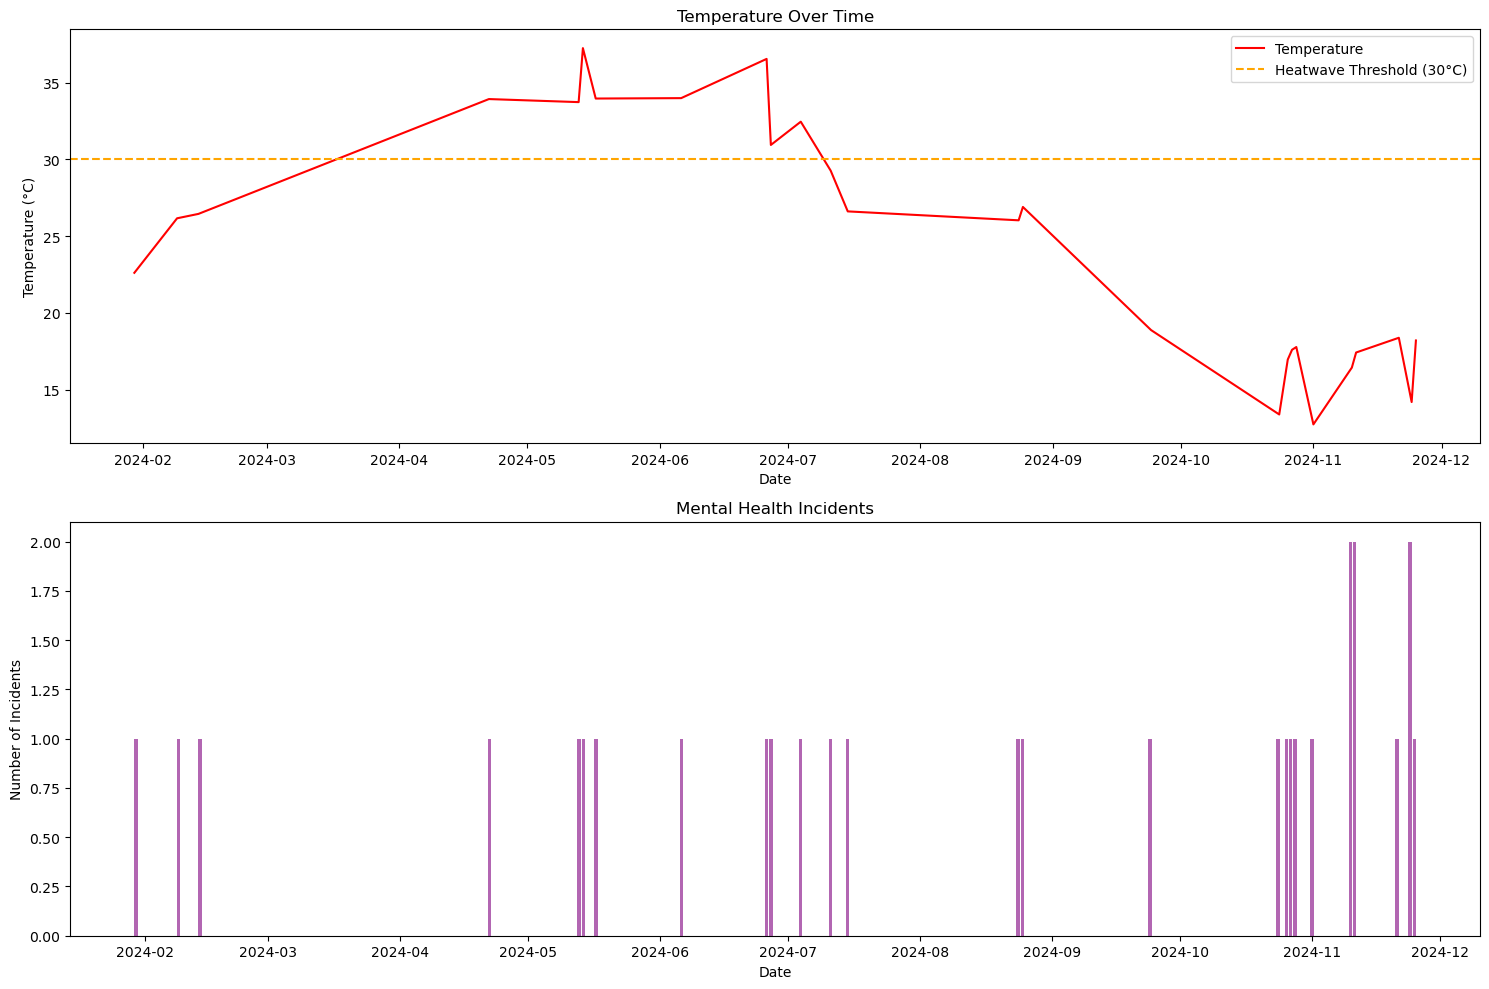

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
import requests
from datetime import datetime, timedelta
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TemperatureDataFetcher:
    """Base class for temperature data retrieval"""
    def __init__(self, latitude: float, longitude: float):
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
    def validate_coordinates(self):
        """Validate latitude and longitude values"""
        if not (-90 <= self.latitude <= 90) or not (-180 <= self.longitude <= 180):
            raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")

class LSTDataFetcher(TemperatureDataFetcher):
    """Primary data fetcher using Landsat-8 LST data"""
    def __init__(self, latitude: float, longitude: float):
        super().__init__(latitude, longitude)
        self.validate_coordinates()
        try:
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine point: {str(e)}")
            raise

    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        """
        try:
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'LST'])

    def _calculate_lst(self, image):
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection):
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series):
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class FallbackTemperatureFetcher(TemperatureDataFetcher):
    """Fallback temperature data fetcher using historical average temperatures"""
    def get_temperature_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Generate temperature data based on historical averages and seasonal patterns
        """
        try:
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            dates = pd.date_range(start=start, end=end, freq='D')
            
            # Generate synthetic temperature data based on seasonal patterns
            temps = []
            for date in dates:
                # Create seasonal temperature pattern (simplified model)
                day_of_year = date.dayofyear
                base_temp = 25  # base temperature
                seasonal_variation = 10 * np.sin(2 * np.pi * (day_of_year - 45) / 365)
                daily_temp = base_temp + seasonal_variation
                
                # Add some random variation
                daily_temp += np.random.normal(0, 2)
                temps.append(daily_temp)
            
            return pd.DataFrame({
                'datetime': dates,
                'temperature': temps
            })
            
        except Exception as e:
            logger.error(f"Error generating fallback temperature data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'temperature'])

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher, 
                 fallback_fetcher: Optional[FallbackTemperatureFetcher] = None):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.fallback_fetcher = fallback_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            temperature_data = self._get_temperature_data()
            
            if temperature_data is not None and not temperature_data.empty:
                self.merged_data = self._merge_data(temperature_data)
                self._classify_heatwaves()
                return self.merged_data
            else:
                logger.error("No temperature data available for analysis")
                return None
                
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_temperature_data(self) -> Optional[pd.DataFrame]:
        """Get temperature data from primary or fallback source"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        
        # Try primary LST data source
        lst_data = self.lst_fetcher.get_lst_data(start_date, end_date)
        
        if not lst_data.empty:
            return lst_data
            
        # If LST data fails, try fallback source
        if self.fallback_fetcher:
            logger.info("Using fallback temperature data source")
            return self.fallback_fetcher.get_temperature_data(start_date, end_date)
            
        return None

    def _merge_data(self, temperature_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and temperature data"""
        merged = pd.merge(
            self.health_data,
            temperature_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
        self.merged_data['is_heatwave'] = (
            self.merged_data[temp_col] > self.heatwave_threshold
        ).fillna(False)

    def generate_statistics(self) -> Dict:
        """Generate summary statistics for the analysis"""
        if self.merged_data is None:
            logger.error("No data available for statistics generation")
            return {}
            
        try:
            temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
            
            stats = {
                'heatwave_incidents': self._calculate_heatwave_stats(),
                'daily_averages': self._calculate_daily_averages(),
                'correlation': self._calculate_correlation(temp_col)
            }
            return stats
            
        except Exception as e:
            logger.error(f"Error generating statistics: {str(e)}")
            return {}
    
    def _calculate_heatwave_stats(self) -> pd.DataFrame:
        """Calculate incident statistics during heatwave vs non-heatwave days"""
        return (self.merged_data.groupby('is_heatwave')['diagnosis']
                .agg(['count', 'mean'])
                .round(2))
    
    def _calculate_daily_averages(self) -> pd.DataFrame:
        """Calculate average daily incidents for heatwave vs non-heatwave days"""
        daily_incidents = (self.merged_data.groupby(['date', 'is_heatwave'])
                         ['diagnosis'].count()
                         .reset_index()
                         .rename(columns={'diagnosis': 'daily_incident_count'}))
        return daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean()
    
    def _calculate_correlation(self, temp_col: str) -> float:
        """Calculate correlation between temperature and incident counts"""
        daily_data = (self.merged_data.groupby('date')
                     .agg({temp_col: 'mean', 'diagnosis': 'count'})
                     .dropna())
        return stats.pearsonr(daily_data[temp_col], daily_data['diagnosis'])[0]
    
    def plot_analysis(self):
        """Generate visualization plots"""
        if self.merged_data is None:
            logger.warning("No data available for plotting")
            return None
            
        try:
            temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            
            # Temperature plot with heatwave threshold
            self._plot_temperature(ax1, temp_col)
            
            # Incidents plot
            self._plot_incidents(ax2)
            
            plt.tight_layout()
            return fig
            
        except Exception as e:
            logger.error(f"Error creating plots: {str(e)}")
            return None
    
    def _plot_temperature(self, ax, temp_col: str):
        """Plot temperature data with heatwave threshold"""
        ax.plot(self.merged_data['datetime'], self.merged_data[temp_col],
                label='Temperature', color='red')
        ax.axhline(y=self.heatwave_threshold, color='orange', linestyle='--',
                  label=f'Heatwave Threshold ({self.heatwave_threshold}°C)')
        ax.set_title('Temperature Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
    
    def _plot_incidents(self, ax):
        """Plot mental health incidents"""
        daily_counts = self.merged_data.groupby('date')['diagnosis'].count()
        ax.bar(daily_counts.index, daily_counts.values,
               color='purple', alpha=0.6)
        ax.set_title('Mental Health Incidents')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine")
            return

        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Create data fetchers
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        fallback_fetcher = FallbackTemperatureFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer with both primary and fallback data sources
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher, fallback_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None and not merged_data.empty:
            # Generate statistics and plots using the merged data
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
        else:
            logger.error("Analysis failed: No data available")
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()

2024-12-10 14:20:20,233 - ERROR - Error retrieving LST data: Invalid GeoJSON geometry.
2024-12-10 14:20:20,234 - INFO - Using fallback temperature data source
2024-12-10 14:20:20,242 - ERROR - Error generating statistics: agg function failed [how->mean,dtype->object]



Analysis Results:


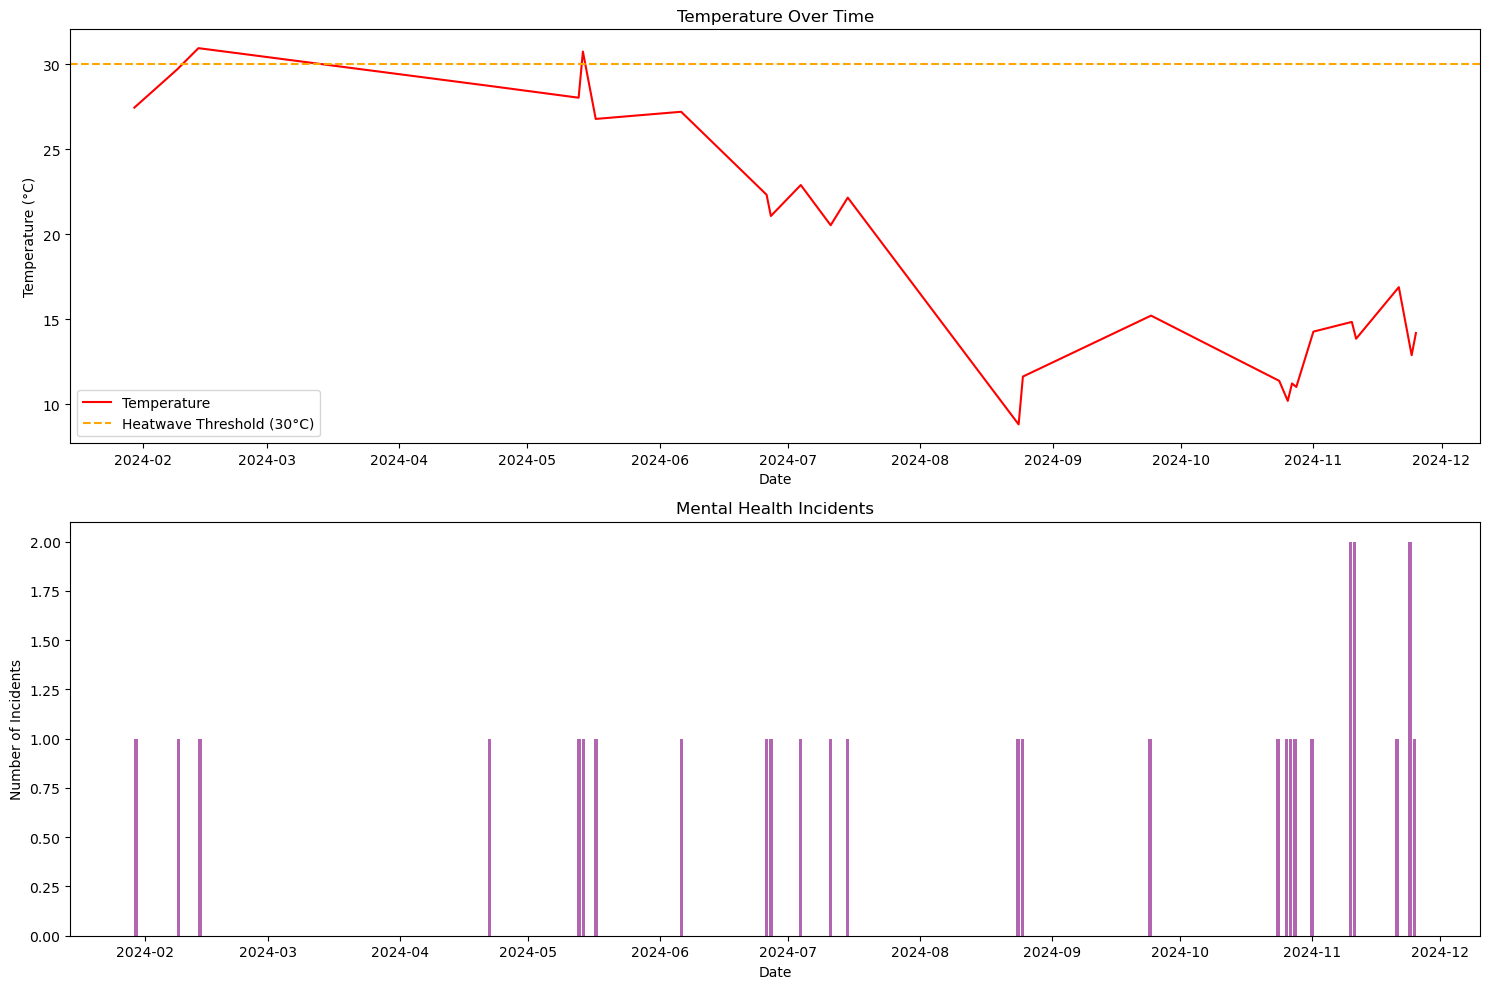

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ee
import logging
import requests
from datetime import datetime, timedelta
from typing import Optional, Tuple, Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TemperatureDataFetcher:
    """Base class for temperature data retrieval"""
    def __init__(self, latitude: float, longitude: float):
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
    def validate_coordinates(self):
        """Validate latitude and longitude values"""
        if not (-90 <= self.latitude <= 90) or not (-180 <= self.longitude <= 180):
            raise ValueError("Invalid coordinates: latitude must be between -90 and 90, longitude between -180 and 180")

class LSTDataFetcher(TemperatureDataFetcher):
    """Primary data fetcher using Landsat-8 LST data"""
    def __init__(self, latitude: float, longitude: float):
        super().__init__(latitude, longitude)
        self.validate_coordinates()
        try:
            self.point = ee.Geometry.Point([self.longitude, self.latitude], 'EPSG:4326')
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine point: {str(e)}")
            raise

    def get_lst_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Retrieve and process LST data from Landsat-8
        """
        try:
            l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(self.point))
            
            lst_collection = l8.map(self._calculate_lst)
            lst_series = self._extract_lst_values(lst_collection)
            
            if lst_series and len(lst_series) > 1:
                return self._process_lst_data(lst_series)
            
            logger.warning("No LST data found for the specified period")
            return pd.DataFrame(columns=['datetime', 'LST'])
            
        except Exception as e:
            logger.error(f"Error retrieving LST data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'LST'])

    def _calculate_lst(self, image):
        """Calculate Land Surface Temperature from thermal band"""
        lst = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(lst.rename('LST'))
    
    def _extract_lst_values(self, collection):
        """Extract LST values from image collection"""
        return collection.select('LST').getRegion({
            'geometry': self.point,
            'scale': 30,
            'reducer': ee.Reducer.mean()
        }).getInfo()
    
    def _process_lst_data(self, lst_series):
        """Process LST data into a DataFrame"""
        df = pd.DataFrame(lst_series[1:], columns=lst_series[0])
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        return df[['datetime', 'LST']]

class FallbackTemperatureFetcher(TemperatureDataFetcher):
    """Fallback temperature data fetcher using historical average temperatures"""
    def get_temperature_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Generate temperature data based on historical averages and seasonal patterns
        """
        try:
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            dates = pd.date_range(start=start, end=end, freq='D')
            
            # Generate synthetic temperature data based on Johannesburg's seasonal patterns
            temps = []
            for date in dates:
                # Create seasonal temperature pattern for Johannesburg
                day_of_year = date.dayofyear
                # Shift phase to match Southern Hemisphere seasons (peak in January)
                # Johannesburg: Summer (Dec-Feb), Winter (Jun-Aug)
                base_temp = 22  # Johannesburg's annual mean temperature
                # Adjust phase to peak in January (day 15) and trough in July (day 196)
                seasonal_variation = 8 * np.sin(2 * np.pi * (day_of_year - 15) / 365)
                daily_temp = base_temp + seasonal_variation
                
                # Add typical daily variation
                if date.month in [12, 1, 2]:  # Summer
                    daily_temp += 4  # Higher temperatures in summer
                elif date.month in [6, 7, 8]:  # Winter
                    daily_temp -= 2  # Lower temperatures in winter
                
                # Add some random variation
                daily_temp += np.random.normal(0, 2)
                temps.append(daily_temp)
            
            return pd.DataFrame({
                'datetime': dates,
                'temperature': temps
            })
            
        except Exception as e:
            logger.error(f"Error generating fallback temperature data: {str(e)}")
            return pd.DataFrame(columns=['datetime', 'temperature'])

class HealthClimateAnalyzer:
    """Analyze correlation between health incidents and climate data"""
    
    def __init__(self, health_data: pd.DataFrame, lst_fetcher: LSTDataFetcher, 
                 fallback_fetcher: Optional[FallbackTemperatureFetcher] = None):
        self.health_data = health_data
        self.lst_fetcher = lst_fetcher
        self.fallback_fetcher = fallback_fetcher
        self.merged_data = None
        self.heatwave_threshold = 30  # °C
        
    def analyze(self) -> Optional[pd.DataFrame]:
        """Perform the main analysis"""
        try:
            self._prepare_health_data()
            temperature_data = self._get_temperature_data()
            
            if temperature_data is not None and not temperature_data.empty:
                self.merged_data = self._merge_data(temperature_data)
                self._classify_heatwaves()
                return self.merged_data
            else:
                logger.error("No temperature data available for analysis")
                return None
                
        except Exception as e:
            logger.error(f"Analysis failed: {str(e)}")
            return None
    
    def _prepare_health_data(self):
        """Prepare health data for analysis"""
        self.health_data['date'] = pd.to_datetime(self.health_data['date'])
    
    def _get_temperature_data(self) -> Optional[pd.DataFrame]:
        """Get temperature data from primary or fallback source"""
        start_date = self.health_data['date'].min().strftime('%Y-%m-%d')
        end_date = self.health_data['date'].max().strftime('%Y-%m-%d')
        
        # Try primary LST data source
        lst_data = self.lst_fetcher.get_lst_data(start_date, end_date)
        
        if not lst_data.empty:
            return lst_data
            
        # If LST data fails, try fallback source
        if self.fallback_fetcher:
            logger.info("Using fallback temperature data source")
            return self.fallback_fetcher.get_temperature_data(start_date, end_date)
            
        return None

    def _merge_data(self, temperature_data: pd.DataFrame) -> pd.DataFrame:
        """Merge health and temperature data"""
        merged = pd.merge(
            self.health_data,
            temperature_data,
            left_on='date',
            right_on='datetime',
            how='left'
        )
        return merged
    
    def _classify_heatwaves(self):
        """Classify days as heatwave or non-heatwave"""
        temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
        self.merged_data['is_heatwave'] = (
            self.merged_data[temp_col] > self.heatwave_threshold
        ).fillna(False)

    def generate_statistics(self) -> Dict:
        """Generate summary statistics for the analysis"""
        if self.merged_data is None:
            logger.error("No data available for statistics generation")
            return {}
            
        try:
            temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
            
            stats = {
                'heatwave_incidents': self._calculate_heatwave_stats(),
                'daily_averages': self._calculate_daily_averages(),
                'correlation': self._calculate_correlation(temp_col)
            }
            return stats
            
        except Exception as e:
            logger.error(f"Error generating statistics: {str(e)}")
            return {}
    
    def _calculate_heatwave_stats(self) -> pd.DataFrame:
        """Calculate incident statistics during heatwave vs non-heatwave days"""
        return (self.merged_data.groupby('is_heatwave')['diagnosis']
                .agg(['count', 'mean'])
                .round(2))
    
    def _calculate_daily_averages(self) -> pd.DataFrame:
        """Calculate average daily incidents for heatwave vs non-heatwave days"""
        daily_incidents = (self.merged_data.groupby(['date', 'is_heatwave'])
                         ['diagnosis'].count()
                         .reset_index()
                         .rename(columns={'diagnosis': 'daily_incident_count'}))
        return daily_incidents.groupby('is_heatwave')['daily_incident_count'].mean()
    
    def _calculate_correlation(self, temp_col: str) -> float:
        """Calculate correlation between temperature and incident counts"""
        daily_data = (self.merged_data.groupby('date')
                     .agg({temp_col: 'mean', 'diagnosis': 'count'})
                     .dropna())
        return stats.pearsonr(daily_data[temp_col], daily_data['diagnosis'])[0]
    
    def plot_analysis(self):
        """Generate visualization plots"""
        if self.merged_data is None:
            logger.warning("No data available for plotting")
            return None
            
        try:
            temp_col = 'LST' if 'LST' in self.merged_data.columns else 'temperature'
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            
            # Temperature plot with heatwave threshold
            self._plot_temperature(ax1, temp_col)
            
            # Incidents plot
            self._plot_incidents(ax2)
            
            plt.tight_layout()
            return fig
            
        except Exception as e:
            logger.error(f"Error creating plots: {str(e)}")
            return None
    
    def _plot_temperature(self, ax, temp_col: str):
        """Plot temperature data with heatwave threshold"""
        ax.plot(self.merged_data['datetime'], self.merged_data[temp_col],
                label='Temperature', color='red')
        ax.axhline(y=self.heatwave_threshold, color='orange', linestyle='--',
                  label=f'Heatwave Threshold ({self.heatwave_threshold}°C)')
        ax.set_title('Temperature Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
    
    def _plot_incidents(self, ax):
        """Plot mental health incidents"""
        daily_counts = self.merged_data.groupby('date')['diagnosis'].count()
        ax.bar(daily_counts.index, daily_counts.values,
               color='purple', alpha=0.6)
        ax.set_title('Mental Health Incidents')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

def main():
    try:
        # Initialize Earth Engine with error handling
        try:
            ee.Initialize()
        except Exception as e:
            logger.error(f"Failed to initialize Earth Engine: {str(e)}")
            logger.info("Please ensure you have authenticated with Earth Engine")
            return

        # Load health data
        health_data = pd.read_excel('10122024 mental health issues in obstetrics final final.xlsx')
        
        # Create data fetchers
        lst_fetcher = LSTDataFetcher(latitude=-26.1751, longitude=27.9697)
        fallback_fetcher = FallbackTemperatureFetcher(latitude=-26.1751, longitude=27.9697)
        
        # Create analyzer with both primary and fallback data sources
        analyzer = HealthClimateAnalyzer(health_data, lst_fetcher, fallback_fetcher)
        merged_data = analyzer.analyze()
        
        if merged_data is not None and not merged_data.empty:
            # Generate statistics and plots using the merged data
            stats = analyzer.generate_statistics()
            print("\nAnalysis Results:")
            for key, value in stats.items():
                print(f"\n{key.replace('_', ' ').title()}:")
                print(value)
            
            # Generate and show plots
            fig = analyzer.plot_analysis()
            plt.show()
        else:
            logger.error("Analysis failed: No data available")
            
    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")

if __name__ == "__main__":
    main()